In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder , OneHotEncoder
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
data = pd.read_csv('Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [29]:
data=data.drop(["RowNumber","CustomerId","Surname"],axis=1)

In [30]:
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])

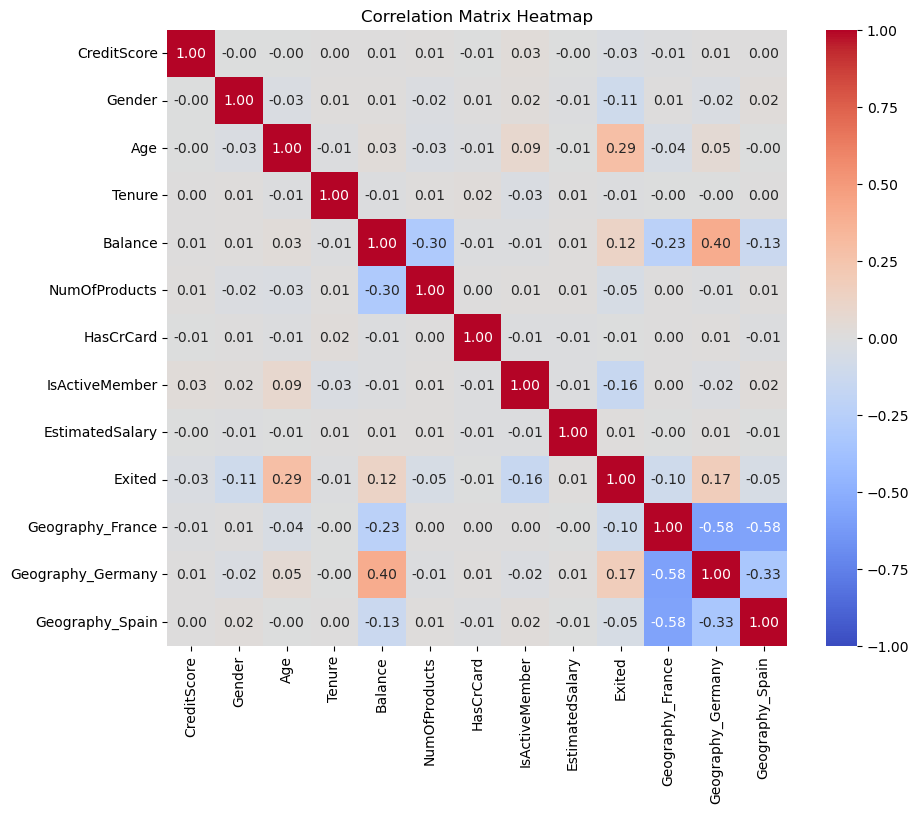

In [13]:
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [25]:
onehot_encoder_geo = OneHotEncoder(handle_unknown='ignore')
geo_encoded = onehot_encoder_geo.fit_transform(data[['Geography']]).toarray()
geo_encoded_df = pd.DataFrame(geo_encoded,columns=onehot_encoder_geo.get_feature_names_out(['Geography']))
geo_encoded_df

,Geography_France,Geography_Germany,Geography_Spain
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0
...,...,...,...
9995,1.0,0.0,0.0
9996,1.0,0.0,0.0
9997,1.0,0.0,0.0
9998,0.0,1.0,0.0


In [31]:
data = pd.concat([data.drop('Geography',axis=1),geo_encoded_df],axis=1)
data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


In [8]:
X = data.drop('EstimatedSalary',axis=1)
y = data['EstimatedSalary']

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
with open('label_encoder.pkl','wb') as f:
    pickle.dump(label_encoder,f)

with open('onehot_encoder_geo.pkl','wb') as f:
    pickle.dump(onehot_encoder_geo,f)
    
with open('scaler.pkl','wb') as f:
    pickle.dump(scaler,f)


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime


In [14]:
model = Sequential([
     Dense(64,activation='relu',input_shape=(X_train.shape[1],)),
     Dense(32,activation='relu'),
     Dense(1,activation='sigmoid')
])
model.compile(optimizer = 'adam',loss='mean_absolute_error',metrics=['mae'])

model.summary()

/home/ayush/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [20]:
history = model.fit(
    X_train,y_train,validation_data=(X_test,y_test),
    epochs=100,
    callbacks=[tensorboard_callback,early_stopping_callback]
)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 100064.4609 - mae: 100064.4609 - val_loss: 98725.0625 - val_mae: 98725.0625
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 100403.9219 - mae: 100403.9219 - val_loss: 98725.0625 - val_mae: 98725.0625
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 100086.9375 - mae: 100086.9375 - val_loss: 98725.0625 - val_mae: 98725.0625
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 100207.4297 - mae: 100207.4297 - val_loss: 98725.0625 - val_mae: 98725.0625
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 100873.4297 - mae: 100873.4297 - val_loss: 98725.0625 - val_mae: 98725.0625
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 100320.5156 - mae: 100320.5156 - val_loss: 98725.0625 - val_mae: 98725.0625
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 100857.3828 - mae: 100857.3828 - val_loss: 98725.0625 - val_mae: 98725.0625
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 

In [22]:
%load_ext tensorboard

In [24]:
%tensorboard --logdir regressionlogs/fit

In [25]:
test_loss , test_mae = model.evaluate(X_test,y_test)
print(test_loss , test_mae)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100870.6641 - mae: 100870.6641
98725.0625 98725.0625


In [ ]:
model.save('regression_model.h5')